# **Money Authenticity Detection for Visual Impaired with CNN**

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from io import BytesIO
from ipywidgets import widgets
from tensorflow.keras.utils import load_img, img_to_array

## **Authenticity Model**

### Dataset exploration
```
.
└── Authenticity/
    ├── Real_Rupiah_Banknotes/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └── Fake_Rupiah_Banknotes/
        ├── image_1.jpg
        ├── image_2.jpg
        └── ...
```

In [ ]:
# Directory that holds the data
DATA_DIR_AUTH = r'C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Datasets\Authenticity'

# Subdirectories for each class
data_dir_real = os.path.join(DATA_DIR_AUTH, 'Real_Rupiah_Banknotes')
data_dir_fake = os.path.join(DATA_DIR_AUTH, 'Fake_Rupiah_Banknotes')

# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(data_dir_real))} images of Real Rupiah Banknotes.")
print(f"There are {len(os.listdir(data_dir_fake))} images of Fake Rupiah Banknotes.")

There are 1590 images of Real Rupiah Banknotes.
There are 306 images of Fake Rupiah Banknotes.


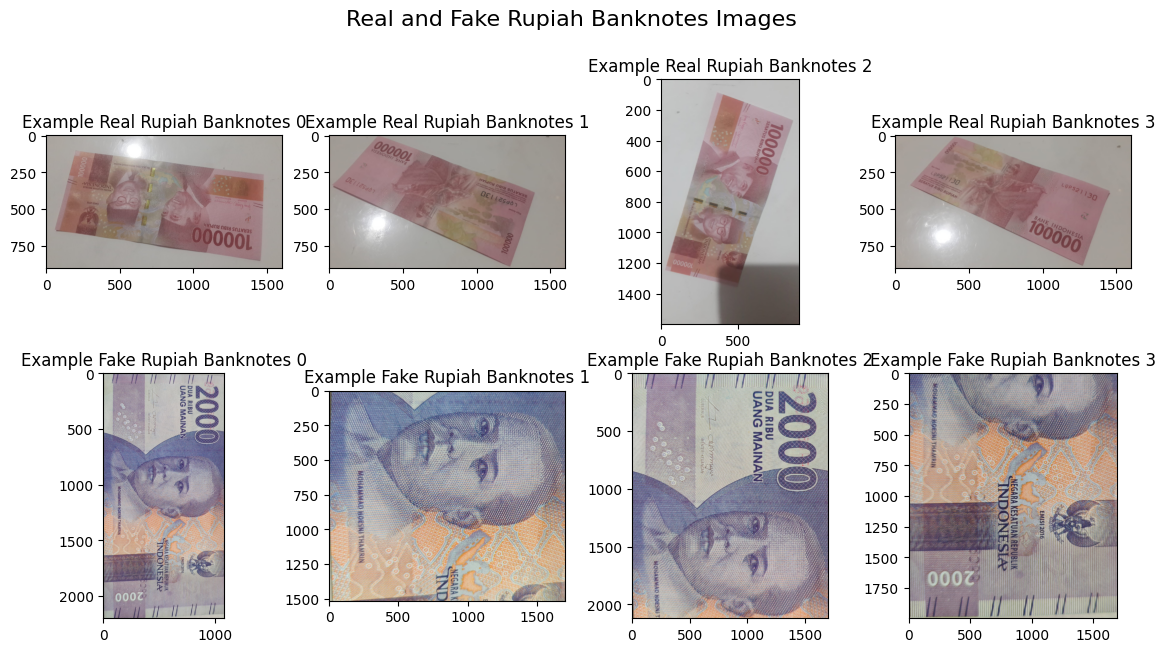

In [ ]:
# Get the filenames for real and fake rupiah banknotes images
real_filenames = [os.path.join(data_dir_real, filename) for filename in os.listdir(data_dir_real)]
fake_filenames = [os.path.join(data_dir_fake, filename) for filename in os.listdir(data_dir_fake)]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Real and Fake Rupiah Banknotes Images', fontsize=16)

# Plot the first 4 images of each class
for i, real_image in enumerate(real_filenames[:4]):
    img = tf.keras.utils.load_img(real_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Real Rupiah Banknotes {i}')

for i, fake_image in enumerate(fake_filenames[:4]):
    img = tf.keras.utils.load_img(fake_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Fake Rupiah Banknotes {i}')

plt.show()

### Create Datasets

In [ ]:
def create_datasets_auth():
    full_dataset_auth = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR_AUTH,
        image_size=(150, 150),
        batch_size=128,
        label_mode='binary',
        shuffle=True,
        seed=42
    )

    # Calculate dataset size
    total_size_auth = len(full_dataset_auth)
    train_size_auth = int(0.6 * total_size_auth)  # 60% for training
    val_size_auth = int(0.2 * total_size_auth)    # 20% for validation
    test_size_auth = total_size_auth - train_size_auth - val_size_auth  # 20% for testing

    # Split dataset manually
    train_dataset_auth = full_dataset_auth.take(train_size_auth)  # Take 60% dataset for training
    remaining_dataset_auth = full_dataset_auth.skip(train_size_auth)  # Remaining dataset

    val_dataset_auth = remaining_dataset_auth.take(val_size_auth)  # Take 20% dataset for validation
    test_dataset_auth = remaining_dataset_auth.skip(test_size_auth)  # Take last 20% dataset for testing

    return train_dataset_auth, val_dataset_auth, test_dataset_auth

In [ ]:
# Create the datasets
train_dataset_auth, val_dataset_auth, test_dataset_auth = create_datasets_auth()

Found 1896 files belonging to 2 classes.


In [ ]:
# Get the first batch of images and labels
for images, labels in train_dataset_auth.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 150, 150, 3)
Shape of batch of labels: (128, 1)


### Create Model

In [ ]:
def create_model_auth():
    model_auth = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.Rescaling(1./255),
        # Convolution and Pooling layers
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('cats') and 1 for the other ('dogs')
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
    ])

    model_auth.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
	)

    return model_auth

In [ ]:
# Create the compiled but untrained model
model_auth = create_model_auth()

In [ ]:
model_auth.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 72, 72, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 34, 34, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 17, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │     2,368,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,393,393 (9.13 MB)

 Trainable params: 2,393,393 (9.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Check model compatibility with dataset
try:
	model_auth.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model_auth.predict(example_batch_images, verbose=False)
	print(f"Your model work well with the datasets.\npredictions have shape: {predictions.shape}")

Your model work well with the datasets.
predictions have shape: (128, 1)


In [ ]:
# Train the model and save the training history
history_auth = model_auth.fit(
	train_dataset_auth,
	epochs=10,
	validation_data=val_dataset_auth,
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6543 - loss: 9.4924 - val_accuracy: 0.8438 - val_loss: 6.1899
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8324 - loss: 5.4172 - val_accuracy: 0.8724 - val_loss: 3.3166
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8343 - loss: 2.9782 - val_accuracy: 0.8490 - val_loss: 1.9554
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8249 - loss: 1.8098 - val_accuracy: 0.8516 - val_loss: 1.3234
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8383 - loss: 1.2684 - val_accuracy: 0.8646 - val_loss: 1.0142
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8401 - loss: 1.0182 - val_accuracy: 0.8411 - val_loss: 0.8968
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8529 - loss: 0.8531 - val_accuracy: 0.8255 - val_loss: 0.8398
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8443 - loss: 0.7861 - val_accuracy: 0.8568 - val_loss: 0.7134
Epoch 9/

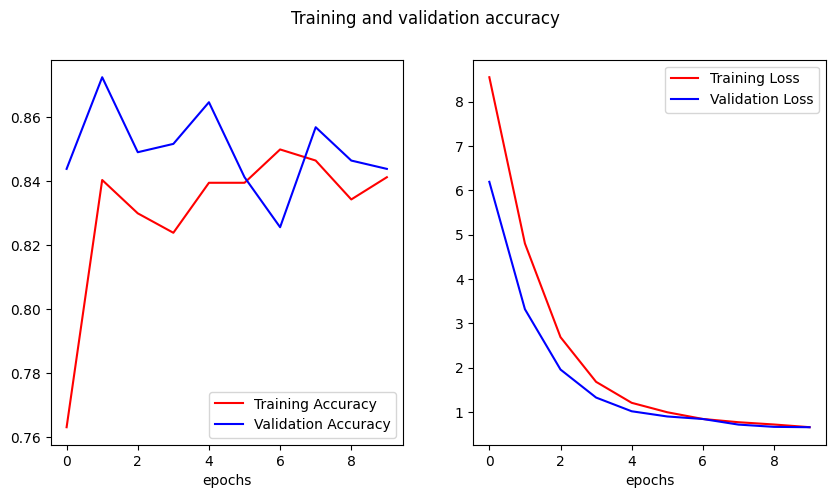

In [ ]:
# Get training and validation accuracies
acc_auth = history_auth.history['accuracy']
val_acc_auth = history_auth.history['val_accuracy']
loss_auth = history_auth.history['loss']
val_loss_auth = history_auth.history['val_loss']

# Get number of epochs
epochs_auth = range(len(acc_auth))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc_auth, val_acc_auth), (loss_auth, val_loss_auth)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs_auth, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs_auth, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

### Test Model

In [ ]:
# Evaluate the model on the test dataset
results = model_auth.evaluate(test_dataset_auth, verbose=1)

# Print test results
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.8341 - loss: 0.6415
Test Loss: 0.6363047957420349
Test Accuracy: 0.8361111283302307


## **Nominal Model**

### Dataset exploration
```
.
└── Nominal/
    ├── 1000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    ├── 2000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    │── 5000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    │── 10000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    │── 20000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    │── 50000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    │── 75000/
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   └── ...
    └──100000/
        ├── image_1.jpg
        ├── image_2.jpg
        └── ...  
        
```

In [ ]:
# Directory that holds the data
DATA_DIR_NOM = r'C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Datasets\Nominal'

# Subdirectories for each class
class_names = os.listdir(DATA_DIR_NOM)

# Display the number of images in each class
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR_NOM, class_name)
    print(f"There are {len(os.listdir(class_dir))} images of {class_name}.")

There are 257 images of 1000.
There are 280 images of 10000.
There are 318 images of 100000.
There are 157 images of 2000.
There are 291 images of 20000.
There are 305 images of 5000.
There are 256 images of 50000.
There are 32 images of 75000.


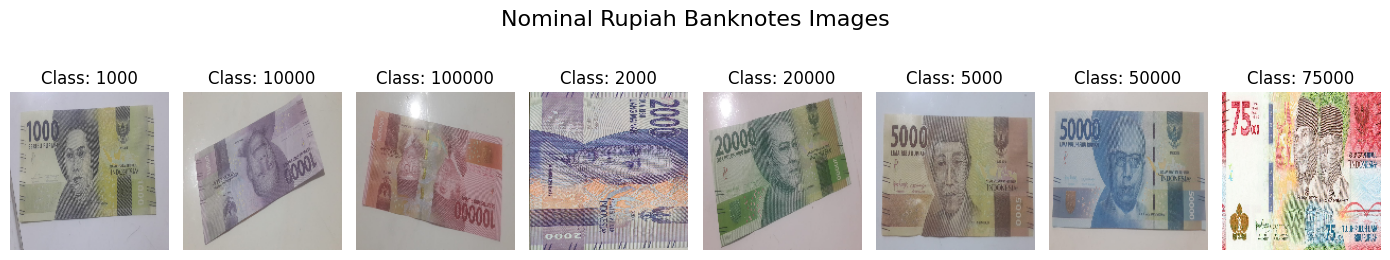

In [ ]:
#  Visualization of some sample images
fig, axes = plt.subplots(1, len(class_names), figsize=(14, 3))
fig.suptitle('Nominal Rupiah Banknotes Images', fontsize=16)

# Plot one image from each class
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(DATA_DIR_NOM, class_name)
    first_image = os.path.join(class_dir, os.listdir(class_dir)[0])  # Gambar pertama di kelas
    img = tf.keras.preprocessing.image.load_img(first_image, target_size=(150, 150))  # Sesuaikan ukuran
    axes[i].imshow(img)
    axes[i].set_title(f'Class: {class_name}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Create Datasets

In [ ]:
def create_datasets_nom():
    full_dataset_nom = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR_NOM,
        image_size=(150, 150),
        batch_size=64,
        label_mode='categorical',
        shuffle=True,
        seed=42
    )

    # Calculate dataset size
    total_size_nom = tf.data.experimental.cardinality(full_dataset_nom).numpy()
    train_size_nom = int(0.6 * total_size_nom)  # 60% for training
    val_size_nom = int(0.2 * total_size_nom)    # 20% for validation
    test_size_nom = total_size_nom - train_size_nom - val_size_nom  # 20% for testing

    # Split dataset manually
    train_dataset_nom = full_dataset_nom.take(train_size_nom)  # Take 60% dataset for training
    remaining_dataset_nom = full_dataset_nom.skip(train_size_nom)  # Remaining dataset

    val_dataset_nom = remaining_dataset_nom.take(val_size_nom)  # Take 20% dataset for validation
    test_dataset_nom = remaining_dataset_nom.skip(test_size_nom)  # Take last 20% dataset for testing

    return train_dataset_nom, val_dataset_nom, test_dataset_nom

In [ ]:
# Create the datasets
train_dataset_nom, val_dataset_nom, test_dataset_nom = create_datasets_nom()

Found 1896 files belonging to 8 classes.


In [ ]:
# Count the total number of batches in the dataset
total_batches_nom = tf.data.experimental.cardinality(train_dataset_nom).numpy() + \
               tf.data.experimental.cardinality(val_dataset_nom).numpy() + \
               tf.data.experimental.cardinality(test_dataset_nom).numpy()

# Count the number of batches per dataset
train_batches_nom = tf.data.experimental.cardinality(train_dataset_nom).numpy()
val_batches_nom = tf.data.experimental.cardinality(val_dataset_nom).numpy()
test_batches_nom = tf.data.experimental.cardinality(test_dataset_nom).numpy()

 # Calculating the percent for each dataset
train_percentage_nom = (train_batches_nom / total_batches_nom) * 100
val_percentage_nom = (val_batches_nom / total_batches_nom) * 100
test_percentage_nom = (test_batches_nom / total_batches_nom) * 100

 # Display the batch count and percent for each dataset
print(f"Train batches: {train_batches_nom} ({train_percentage_nom:.2f}%)")
print(f"Validation batches: {val_batches_nom} ({val_percentage_nom:.2f}%)")
print(f"Test batches: {test_batches_nom} ({test_percentage_nom:.2f}%)")


Train batches: 18 (60.00%)
Validation batches: 6 (20.00%)
Test batches: 6 (20.00%)


In [ ]:
# Get the first batch of images and labels
for images, labels in train_dataset_nom.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (64, 150, 150, 3)
Shape of batch of labels: (64, 8)


### Create Augmentation Model

In [ ]:
def create_augmentation_model_nom():
    FILL_MODE_NOM = 'nearest'

    augmentation_model = tf.keras.Sequential([
		tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE_NOM),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE_NOM),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE_NOM),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2)
    ])

    return augmentation_model

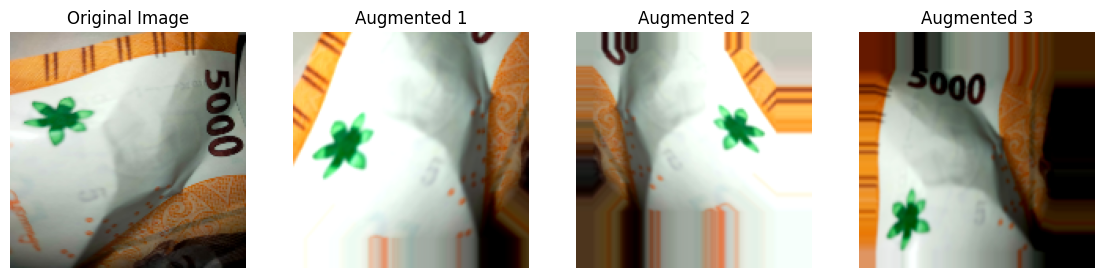

In [ ]:
# Load your model for augmentation
data_augmentor_nom = create_augmentation_model_nom()

# Take a sample image (assuming example_batch_images is predefined)
sample_image_nom = tf.keras.utils.array_to_img(example_batch_images[0])

# Initialize list to hold images
images_nom = [sample_image_nom]

# Apply random augmentation 3 times
for _ in range(3):
    image_aug_nom = data_augmentor_nom(tf.expand_dims(sample_image_nom, axis=0))
    image_aug_nom = tf.keras.utils.array_to_img(tf.squeeze(image_aug_nom))
    images_nom.append(image_aug_nom)

# Plot the images
fig, axs = plt.subplots(1, 4, figsize=(14, 7))

for ax, image_nom, title in zip(axs, images_nom, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image_nom, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

### Create Model

In [ ]:
def create_model_nom():
    augmentation_layers_nom = create_augmentation_model_nom()

    model_nom = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        augmentation_layers_nom,
        tf.keras.layers.Rescaling(1./255),
        # Convolution and Pooling layers
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('cats') and 1 for the other ('dogs')
        tf.keras.layers.Dense(8, activation='softmax', kernel_regularizer=l2(0.01))
    ])

    model_nom.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
	)

    return model_nom

In [ ]:
# Create the compiled but untrained model
model_nom = create_model_nom()

In [ ]:
print(f'Input shape: {model_nom.input_shape}')
print(f'Output shape: {model_nom.output_shape}')

Input shape: (None, 150, 150, 3)
Output shape: (None, 8)


In [ ]:
model_nom.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_35 (Sequential)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 72, 72, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 34, 34, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 17, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 4624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │     2,368,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,396,984 (9.14 MB)

 Trainable params: 2,396,984 (9.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for images, labels in train_dataset_nom.take(1):
	example_batch_images = images
	example_batch_labels = labels

try:
	model_nom.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model_nom.predict(example_batch_images, verbose=False)
	print(f"Your model work well with the datasets.\npredictions have shape: {predictions.shape}")

Your model work well with the datasets.
predictions have shape: (64, 8)


In [ ]:
# Train the model and save the training history
history_nom = model_nom.fit(
	train_dataset_nom,
	epochs=50,
	validation_data=val_dataset_nom,
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 607ms/step - accuracy: 0.2018 - loss: 9.7966 - val_accuracy: 0.2214 - val_loss: 4.6723
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 726ms/step - accuracy: 0.2302 - loss: 3.9297 - val_accuracy: 0.3151 - val_loss: 2.6065
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 668ms/step - accuracy: 0.3043 - loss: 2.4733 - val_accuracy: 0.2500 - val_loss: 2.2835
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 639ms/step - accuracy: 0.3024 - loss: 2.1932 - val_accuracy: 0.3073 - val_loss: 2.0333
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3448 - loss: 2.0711 - val_accuracy: 0.3359 - val_loss: 1.9628
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 640ms/step - accuracy: 0.3893 - loss: 1.9411 - val_accuracy: 0.3880 - val_loss: 1.9085
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3914 - loss: 1.9455 - val_accuracy: 0.5078 - val_loss: 1.7004
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 635ms/step - accuracy: 0.4585 - loss: 1.8071 - val_accuracy: 

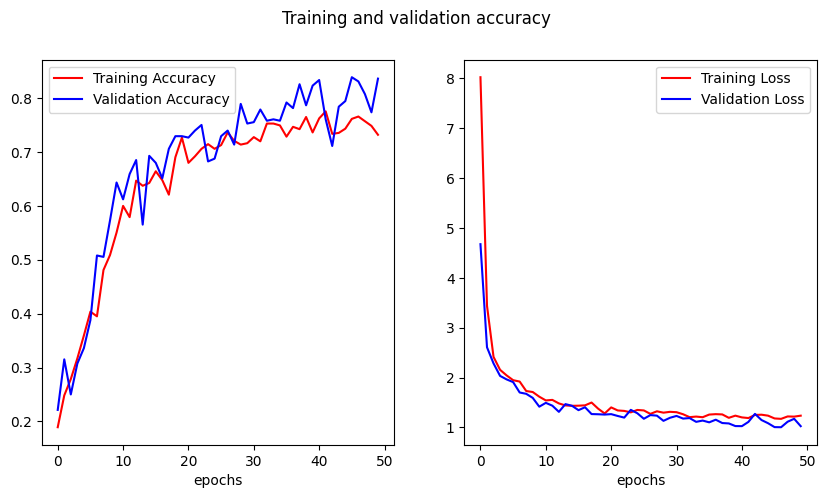

In [ ]:
# Get training and validation accuracies
acc_nom = history_nom.history['accuracy']
val_acc_nom = history_nom.history['val_accuracy']
loss_nom = history_nom.history['loss']
val_loss_nom = history_nom.history['val_loss']

# Get number of epochs
epochs_nom = range(len(acc_nom))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc_nom, val_acc_nom), (loss_nom, val_loss_nom)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs_nom, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs_nom, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

### Test Model

In [ ]:
# Evaluate the model on the test dataset
results = model_nom.evaluate(test_dataset_nom, verbose=1)

# Print test results
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.8574 - loss: 0.9579
Test Loss: 0.9914721250534058
Test Accuracy: 0.8388888835906982


## **All Model Application**

In [ ]:
def create_combined_model(model_auth, model_nom):
    # Input image
    input_image = tf.keras.Input(shape=(150, 150, 3))

    # Authenticity prediction
    authenticity_output = model_auth(input_image)

    # Nominal prediction
    nominal_output = model_nom(input_image)

    # Combine both model
    combined_model = tf.keras.Model(inputs=input_image, outputs=[authenticity_output, nominal_output])

    # Compile the combined model
    combined_model.compile(optimizer='adam',
                           loss=['binary_crossentropy', 'categorical_crossentropy'],
                           metrics=['accuracy'])

    return combined_model

### Test with single file from directory

In [ ]:
def predict_image(file_path, combined_model, nominal_values):
    image = load_img(file_path, target_size=(150, 150))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    authenticity_pred, nominal_pred = combined_model.predict(image, verbose=0)

    authenticity = "Real" if authenticity_pred[0] > 0.5 else "Fake"

    nominal = nominal_values[np.argmax(nominal_pred)]

    return authenticity, nominal

file_path = r'C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Data Example\Uang Fake\Uang Fake 5000.jpg'

nominal_values = ['1000', '2000', '5000', '10000', '20000', '50000', '75000', '100000']

combined_model = create_combined_model(model_auth, model_nom)

authenticity, nominal = predict_image(file_path, combined_model, nominal_values)

print(f"File: {file_path}")
print(f"Authenticity: {authenticity}")
print(f"Nominal: Rp{nominal}")

File: C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Data Example\Uang Fake\Uang Fake 5000.jpg
Authenticity: Fake
Nominal: Rp50000


### Test with all file in directory

In [ ]:
test_dir = r'C:\Users\LOQ\Desktop\Folder Kuliah\Semester 5\Capstone Project Aing\Data Example\Uang Fake'

def predict_image_from_path(file_path, combined_model, nominal_values):
    image = load_img(file_path, target_size=(150, 150))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    authenticity_pred, nominal_pred = combined_model.predict(image, verbose=0)

    authenticity = "Real" if authenticity_pred[0] > 0.5 else "Fake"

    nominal = nominal_values[np.argmax(nominal_pred)]

    return authenticity, nominal

nominal_values = ['1000', '2000', '5000', '10000', '20000', '50000', '75000', '100000']

for file_name in os.listdir(test_dir):
    file_path = os.path.join(test_dir, file_name)
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Validasi tipe file
        authenticity, nominal = predict_image_from_path(file_path, combined_model, nominal_values)
        print(f"{file_name}: Authenticity: {authenticity}, Nominal: Rp{nominal}")

Uang Fake 1000.png: Authenticity: Real, Nominal: Rp10000
Uang Fake 10000.jpg: Authenticity: Real, Nominal: Rp2000
Uang Fake 100000.jpg: Authenticity: Real, Nominal: Rp5000
Uang Fake 2000.jpg: Authenticity: Real, Nominal: Rp2000
Uang Fake 20000.jpg: Authenticity: Fake, Nominal: Rp1000
Uang Fake 5000.jpg: Authenticity: Fake, Nominal: Rp50000
Uang Fake 50000.jpg: Authenticity: Real, Nominal: Rp5000
Uang Fake 75000.jpg: Authenticity: Real, Nominal: Rp50000


### Test with choosing file

In [ ]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = combined_model.predict(image, verbose=0)

    authenticity_prediction = prediction[0][0]
    nominal_prediction = prediction[1]

    with out:
        if authenticity_prediction > 0.5:
            print(f"{filename} is a fake rupiah banknotes")
        else:
            print(f"{filename} is a real rupiah banknotes")

        predicted_nominal = np.argmax(nominal_prediction)
        print(f"Predicted nominal: {nominal_values[predicted_nominal]}")

def on_upload_change(change):
    items = change.new
    for item in items:
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()